## Segmenting NBA Players with the K-Means Algorithm and PCA

I just finished my first semester of grad school at Georgia Tech, where I'm completing my MS in Data Analytics. I've been pretty eager for some free time to practice and apply the things I've learned on topics that I am passionate about. Naturally, I started with an NBA stats dataset. The data comes from https://www.basketball-reference.com, where I get almost all of my NBA data.

In this analysis, I'm going to try to segment NBA players into talent buckets using the k-means clustering algorithm, which I'll explain later in the notebook. Before that, getting to the algorithm and the vizualization of those results, I have to do some data cleaning to get my dataset in the form it needs to be in.

Additionally, I'm going to tie in one of the more interesting topics I learned about this semester: Principal Component Analysis (PCA), which I'll also get to a little later.

In [1]:
#importing all the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.cluster.vq import kmeans2


In [2]:
path = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\K-Means Clustering on NBA Players\bballref1718.xlsx'

## Importing the Datasets
I'm bringing in both advanced stats and the usual per-game stats for the analysis. Here are the first 5 rows from each dataset:

In [3]:
advanced_stats = pd.read_excel(path,'Advanced')
pergame_stats = pd.read_excel(path, 'PerGame')

display(advanced_stats.head())

display(pergame_stats.head())

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,James Harden\hardeja01,SG,28,HOU,72,2551,29.8,0.619,0.498,0.502,...,15.1,36.1,11.6,3.8,15.4,0.289,9.6,1.3,10.9,8.3
1,LeBron James\jamesle01,PF,33,CLE,82,3026,28.6,0.621,0.257,0.336,...,16.1,31.6,11.0,3.0,14.0,0.221,7.6,2.0,9.6,8.9
2,Karl-Anthony Towns\townska01,C,22,MIN,82,2918,24.9,0.646,0.243,0.343,...,10.5,22.9,10.6,3.4,14.0,0.230,4.4,1.1,5.5,5.5
3,Anthony Davis\davisan02,PF,24,NOP,75,2727,28.9,0.612,0.111,0.409,...,8.6,30.0,8.8,4.9,13.7,0.241,2.8,2.3,5.2,4.9
4,Damian Lillard\lillada01,PG,27,POR,73,2670,25.2,0.594,0.445,0.380,...,11.1,30.6,9.9,2.7,12.6,0.227,7.7,-1.0,6.7,5.9


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,Alex Abrines\abrinal01,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,Quincy Acy\acyqu01,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,Steven Adams\adamsst01,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9
3,Bam Adebayo\adebaba01,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9
4,Arron Afflalo\afflaar01,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4


## Cleaning the Data
The first thing I noticed in the data is that the player names all have back-slashes and player IDs. I'm going to just keep the player names and get rid of everything else.

After that, I'm going to take care of the issue that some players play on multiple teams throughout the year. For simplicity purposes, I'll just use the team that they played the most games with.

In [4]:
#Cleaning Data
advanced_stats['Player'] = advanced_stats['Player'].apply(lambda x: x.split('\\')[0])
pergame_stats['Player'] = pergame_stats['Player'].apply(lambda x: x.split('\\')[0])
display(pergame_stats.head())

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,Alex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9
3,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9
4,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4


In [5]:
#Some players played for multiple teams - we want the team they played the most games for
max_team = pergame_stats.groupby(by = ['Player'], as_index=False)['G'].max()
pergame_stats2 = max_team.merge(pergame_stats, how = 'left')
pergame_stats2.head()

,Player,G,Pos,Age,Tm,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,Aaron Brooks,32,PG,33,MIN,1,5.9,0.9,2.2,0.406,...,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
1,Aaron Gordon,58,PF,22,ORL,57,32.9,6.5,14.9,0.434,...,0.698,1.5,6.4,7.9,2.3,1.0,0.8,1.8,1.9,17.6
2,Aaron Harrison,9,SG,23,DAL,3,25.9,2.1,7.7,0.275,...,0.765,0.4,2.2,2.7,1.2,1.0,0.2,0.3,3.0,6.7
3,Aaron Jackson,1,PG,31,HOU,0,35.0,3.0,9.0,0.333,...,0.500,2.0,1.0,3.0,1.0,0.0,0.0,1.0,4.0,8.0
4,Abdel Nader,48,SF,24,BOS,1,10.9,1.0,3.1,0.336,...,0.590,0.3,1.2,1.5,0.5,0.3,0.2,0.7,0.9,3.0


One more thing I want to look at is a minutes played minimum. Some players might have very few total minutes played and could skew the results or impact the k-means algorithm. I'll take a look at the summary statistics of the minutes column, and pick  number above the 25th percentile - in this case, 250 minutes, which leaves us with 403 players.

In [6]:
#Get rid of players with below 250 minutes - these could skew the data
print(advanced_stats['MP'].describe())

advanced2 = advanced_stats[advanced_stats['MP'] > 250]
print()
print("Total Players that played at least 250 minutes:",len(advanced2))

count     540.000000
mean     1099.740741
std       856.743123
min         1.000000
25%       241.500000
50%      1038.500000
75%      1808.500000
max      3026.000000
Name: MP, dtype: float64

Total Players that played at least 250 minutes: 403


In [7]:
#Variable selection
df1 = advanced2[['Player','PER','TS%','USG%','WS',]]
df2 = pergame_stats2[['Player','TRB','AST','BLK','STL','PS/G','FT%']]

df3 = df1.merge(df2, how = 'left')
df3.head()

,Player,PER,TS%,USG%,WS,TRB,AST,BLK,STL,PS/G,FT%
0,James Harden,29.8,0.619,36.1,15.4,5.4,8.8,0.7,1.8,30.4,0.858
1,LeBron James,28.6,0.621,31.6,14.0,8.6,9.1,0.9,1.4,27.5,0.731
2,Karl-Anthony Towns,24.9,0.646,22.9,14.0,12.3,2.4,1.4,0.8,21.3,0.858
3,Anthony Davis,28.9,0.612,30.0,13.7,11.1,2.3,2.6,1.5,28.1,0.828
4,Damian Lillard,25.2,0.594,30.6,12.6,4.5,6.6,0.4,1.1,26.9,0.916


In [8]:
#create variable only matrix
df4 = df3.drop(labels = 'Player',axis =1)
df4 = df4.fillna(0)

In [9]:
pca = PCA(n_components=2)
fit = pca.fit(df4).transform(df4)
print(pca.explained_variance_ratio_)

[0.74538528 0.13135334]


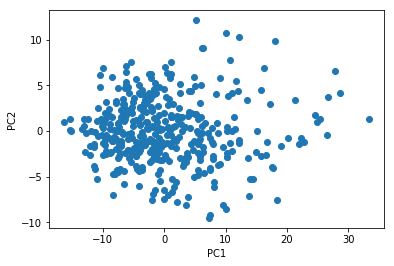

In [10]:
pca_vars = pd.DataFrame(fit, columns = ['PC1','PC2'])
plt.scatter(pca_vars['PC1'],pca_vars['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2');


**Why 2 principal components?**

How do we know if the PCA analysis is a good representation of our data? I just picked the first two principal components because 2-dimensional graphs are easy to interpret. I'll do some additional analysis to see how much variance our first two principal components (and more components) capture in the data

Two principal components explained variance: 0.876738616639023


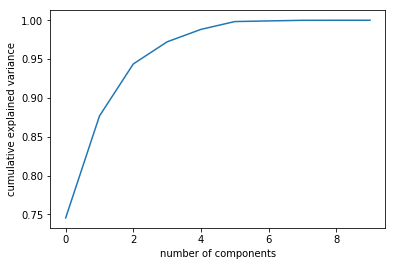

In [11]:
pca = PCA().fit(df4)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print("Two principal components explained variance:", sum(pca.explained_variance_ratio_[0:2]))

**Interpreting the Explained Variance Ratio**

The plot above shows that after 5 principal components are used, the additional variance added is minimal. My ininital choice of 2 principal components actually accounts for almost 88% of the variance in the dataset. For plotting purposes and moving forward in the analysis, I'll stick with the 2 components. The next step will be running the k-means algorithm on the data, using the principal components of the dataset that we just came up with.


## The k-means clustering algorithm
K-means is one of the simplest unsupervised learning algorithms to solve clustering problems. k-means is an unsupervised algorithm because we don't have any labels for the points (for example: position, all-star, all-nba team). We're simply plugging in the data points (players), and letting k-means determine the labels. The only thing we actually choose is the number of clusters we want to segment the data into. Intuitively, each cluster should reflect some sort of similar grouping. My objective is to segment players into buckets of talent and style of play. I purposely left out position in the variables. If I were to add position, I would likely only add in indicators of "Gaurd" and "Big", given the current state of the talent and style of play in today's NBA.


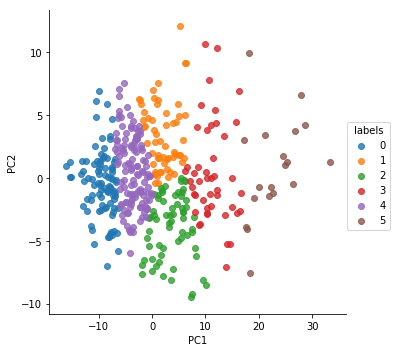

In [12]:
%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

centroids = kmeans2(pca_vars, k = 6)[0]
labels = kmeans2(pca_vars, k = 6)[1]

        
pca_vars['labels'] = labels
sns.lmplot(x = 'PC1', y = 'PC2', data = pca_vars,hue ='labels', fit_reg= False)

**k-means results**

Again, I arbitrarily chose 6 clusters for the algorithm to compute. I chose this based on my knowledge of the game, and more specifically, the NBA. I'm guessing that there are about 5-7 "levels" of players in the NBA. There's a top tier of talent of about 20 players in the NBA (5 or 6 that are elite every year), and after that, talent kind of drops off in steps. the rest of the league sort of fits into roles based on the team that they are on. 

We can't really extract any meaningful information from the graph above. It's a simple scatter plot using our two principal components from earlier- and it also includes our clusters on the color palette. I'll add the labels from our kmeans algorithm to our initial dataset, so we can map some labels to actual player names.

In [13]:
player_labels = pca_vars.copy()
player_labels['Player'] = df3['Player']
player_labels.head(10)

,PC1,PC2,labels,Player
0,33.304775,1.306661,5,James Harden
1,28.697069,4.193766,5,LeBron James
2,18.096868,9.910875,5,Karl-Anthony Towns
3,27.825381,6.608051,5,Anthony Davis
4,24.901751,1.035778,5,Damian Lillard
5,26.699591,3.737971,5,Giannis Antetokounmpo
6,21.248628,3.413503,5,LaMarcus Aldridge
7,16.247584,6.928449,3,Nikola Jokic
8,24.548516,1.720503,5,Kevin Durant
9,12.115571,10.328772,3,Andre Drummond


## K-means Results and Tableau Link

Looking at just a subset of the data (our intial data was sorted by PER), we can see that all of the first 10 players were labeled "2" except for Karl-Anthony Towns, Nikola Jokic, and Andre Drummond. I'm going to guess that our "2" group is our top-tier talent. It's a little surprsing that KAT isn't in that group, but he had somewhat of a poor year last year compared to expectations. One other note is that all three of those guys not in the top-tier group are all bigs, so that makes some sense.

The rest of my analysis (the fun part) will be completed in tableau. It'll be much easier and more interactive to vizualize this data with some of the features tableau offers. The last step I'll do in this notebook is run the k-means algorithm on the entire dataset- I'll do this just to have a comparison of the performance of the two models (Two principal components vs full dataset).

The remaining code cells join the cluster labels with the stats and then extract the dataset to a csv file.

In [14]:

Cluster1 = player_labels.merge(advanced2, on = 'Player',how = 'left')
Cluster2 = Cluster1.merge(pergame_stats,on = 'Player', how = 'left')
Cluster2.head()

,PC1,PC2,labels,Player,Pos_x,Age_x,Tm_x,G_x,MP_x,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,33.304775,1.306661,5,James Harden,SG,28,HOU,72,2551,29.8,...,0.858,0.6,4.8,5.4,8.8,1.8,0.7,4.4,2.3,30.4
1,28.697069,4.193766,5,LeBron James,PF,33,CLE,82,3026,28.6,...,0.731,1.2,7.5,8.6,9.1,1.4,0.9,4.2,1.7,27.5
2,18.096868,9.910875,5,Karl-Anthony Towns,C,22,MIN,82,2918,24.9,...,0.858,2.9,9.4,12.3,2.4,0.8,1.4,1.9,3.5,21.3
3,27.825381,6.608051,5,Anthony Davis,PF,24,NOP,75,2727,28.9,...,0.828,2.5,8.6,11.1,2.3,1.5,2.6,2.2,2.1,28.1
4,24.901751,1.035778,5,Damian Lillard,PG,27,POR,73,2670,25.2,...,0.916,0.8,3.6,4.5,6.6,1.1,0.4,2.8,1.6,26.9


In [15]:
path2 = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\K-Means Clustering on NBA Players\cluster_output.csv'

In [16]:
#Extract the File
Cluster2.to_csv(path2, index = False)

In [19]:
#Performing kmeans on the entire dataset
df5 = df4.copy()
centroids = kmeans2(df5, k = 6)[0]
labels = kmeans2(df5, k = 6)[1]

In [20]:
df5['Player'] = df3['Player']
df5['Clusters'] = labels
Clusters3 = df5.copy()

In [21]:
Clusters3.head()

,PER,TS%,USG%,WS,TRB,AST,BLK,STL,PS/G,FT%,Player,Clusters
0,29.8,0.619,36.1,15.4,5.4,8.8,0.7,1.8,30.4,0.858,James Harden,1
1,28.6,0.621,31.6,14.0,8.6,9.1,0.9,1.4,27.5,0.731,LeBron James,1
2,24.9,0.646,22.9,14.0,12.3,2.4,1.4,0.8,21.3,0.858,Karl-Anthony Towns,1
3,28.9,0.612,30.0,13.7,11.1,2.3,2.6,1.5,28.1,0.828,Anthony Davis,1
4,25.2,0.594,30.6,12.6,4.5,6.6,0.4,1.1,26.9,0.916,Damian Lillard,1


In [22]:
#Extract the File
path2 = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\K-Means Clustering on NBA Players\cluster_output2.csv'
Clusters3.to_csv(path2, index = False)